Experiment to use lora to make a lying model. Here we think of Lora as a probe, as it acts in a very similar way - modifying the residual stream.

Then the hope is it will assist at lie detecting and generalize to unseen dataset

- https://github.dev/JD-P/minihf/blob/b54075c34ef88d9550e37fdf709e78e5a68787c4/lora_tune.py
- https://github.com/jonkrohn/NLP-with-LLMs

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

plt.style.use("ggplot")

from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)

import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")


# # quiet please
torch.set_float32_matmul_precision("medium")
import warnings

warnings.filterwarnings("ignore", ".*does not have many workers.*")
# warnings.filterwarnings(
#     "ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*"
# )
# warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl
from src.datasets.dm import DeceptionDataModule
from src.models.pl_lora_ft import AtapterFinetuner

from src.config import ExtractConfig
from src.prompts.prompt_loading import load_preproc_dataset, load_preproc_datasets
from src.models.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.models.phi.model_phi import PhiForCausalLMWHS


## Parameters


In [3]:
# params
max_epochs = 6
device = "cuda:0"

cfg = ExtractConfig(
    max_examples=(300, 100),
    # model="wassname/phi-1_5-w_hidden_states",
    # batch_size=3,
    # model="wassname/phi-2-w_hidden_states",
    model="Walmart-the-bag/phi-2-uncensored",
    batch_size=1,
    prompt_format="phi",
)


## Load model

In [4]:
model, tokenizer = load_model(
    cfg.model,
    device=device,
    model_class=PhiForCausalLMWHS,
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


In [5]:
# TODO I would like to only have biases, but for now lets just try a very small intervention on the last parts of a layer...
peft_config = LoraConfig(
    target_modules=[
        "out_proj",
        "mlp.fc2",
        # "mlp.fc1",
        "Wqkv",
        # 'inner_attn',
        # 'inner_cross_attn',
    ],  # only the layers that go directly to the residual
    # bias="lora_only",
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=4,
    lora_alpha=8,
    lora_dropout=0.0,
)


# peft_config = IA3Config(
#     task_type=TaskType.SEQ_CLS, target_modules=[ "out_proj",
#         "mlp.fc2",], feedforward_modules=["out_proj", "mlp.fc2",]
# )
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 3,604,480 || all params: 2,783,288,320 || trainable%: 0.12950436985270716


In [6]:
model


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLMWHS(
      (transformer): PhiModel(
        (embd): Embedding(
          (wte): Embedding(51200, 2560)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (h): ModuleList(
          (0-31): 32 x ParallelBlock(
            (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (resid_dropout): Dropout(p=0.1, inplace=False)
            (mixer): MHA(
              (rotary_emb): RotaryEmbedding()
              (Wqkv): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=7680, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=7680, bias=False)
        

## Load datasets

In [7]:
N = sum(cfg.max_examples)
ds_tokens = load_preproc_datasets(
    cfg.datasets,
    tokenizer,
    N=N,
    seed=cfg.seed,
    num_shots=cfg.num_shots,
    max_length=cfg.max_length,
    prompt_format=cfg.prompt_format,
)
ds_tokens


2023-12-23 16:48:46.508 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:350 - setting tokenizer chat template to phi
2023-12-23T16:48:46.508786+0800 INFO setting tokenizer chat template to phi
2023-12-23 16:48:46.577 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:381 - median token length: 443.0 for amazon_polarity. max_length=776
2023-12-23T16:48:46.577347+0800 INFO median token length: 443.0 for amazon_polarity. max_length=776
2023-12-23 16:48:46.578 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:385 - truncation rate: 0.00% on amazon_polarity
2023-12-23T16:48:46.578449+0800 INFO truncation rate: 0.00% on amazon_polarity
2023-12-23 16:48:46.587 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - num_rows (after filtering out truncated rows) 604=>604
2023-12-23T16:48:46.587310+0800 INFO num_rows (after filtering out truncated rows) 604=>604
2023-12-23 16:48:46.654 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:381 -

Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 402
})

In [8]:
ds_tokens2 = load_preproc_datasets(
    cfg.datasets_ood,
    tokenizer,
    N=N // 2,
    seed=cfg.seed,
    num_shots=cfg.num_shots,
    max_length=cfg.max_length,
    prompt_format=cfg.prompt_format,
)
ds_tokens2


2023-12-23 16:48:46.761 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:381 - median token length: 298.5 for glue:qnli. max_length=776
2023-12-23T16:48:46.761344+0800 INFO median token length: 298.5 for glue:qnli. max_length=776
2023-12-23 16:48:46.762 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:385 - truncation rate: 0.00% on glue:qnli
2023-12-23T16:48:46.762390+0800 INFO truncation rate: 0.00% on glue:qnli
2023-12-23 16:48:46.769 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - num_rows (after filtering out truncated rows) 604=>604
2023-12-23T16:48:46.769346+0800 INFO num_rows (after filtering out truncated rows) 604=>604


Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 201
})

## custom models

In [9]:
from src.models.pl_lora_ft import AtapterFinetuner
from src.helpers.scores import select

class AtapterFinetunerLie(AtapterFinetuner):
    def get_loss(self, batch, out, out_a):
        """
        simply train it to lie
        """

        log_probs_a = torch.log_softmax(out_a["logits"][:, -1,], -1,)

        # batch['instructed_to_lie']
        lie_label = ~batch['label_true']
        choice_ids1 = select(batch["choice_ids"][:, :, 0], lie_label.long())
        choice_ids2 = select(batch["choice_ids"][:, :, 1], lie_label.long())
        loss1 = F.nll_loss(log_probs_a, target=choice_ids1)
        loss2 = F.nll_loss(log_probs_a, target=choice_ids2)
        loss = (loss1 + loss2) / 2

        return loss, None, None


In [10]:
from src.models.pl_lora_ft import AtapterFinetuner
from src.helpers.scores import select


class AtapterFinetunerToldToLie(AtapterFinetuner):
    def get_loss(self, batch, out, out_a):
        """
        train it to lie when instructed
        """

        end_logits = out_a["logits"][
            :,
            -1,
        ]
        log_probs_a = torch.log_softmax(end_logits, -1)

        lie_label = batch["label_true"] ^ batch["instructed_to_lie"]
        choice_ids1 = select(batch["choice_ids"][:, :, 0], lie_label.long())
        choice_ids2 = select(batch["choice_ids"][:, :, 1], lie_label.long())
        loss1 = F.nll_loss(log_probs_a, target=choice_ids1)
        loss2 = F.nll_loss(log_probs_a, target=choice_ids2)
        loss = (loss1 + loss2) / 2

        return loss, None, None


In [11]:
model_cls = AtapterFinetunerToldToLie


## Train

In [12]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size)
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()


In [13]:
b = next(iter(dl_train))
print(b.keys(), b["input_ids"].shape)
c_in = b["input_ids"].shape[1]
c_in


dict_keys(['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids']) torch.Size([1, 776])


776

In [14]:
net = model_cls(
    model, tokenizer, lr=5e-3, weight_decay=1e-5, total_steps=len(dl_train) * max_epochs
)

print(c_in)


776


In [15]:
# # debug
# with torch.no_grad():
#     o = net.training_step(b, None)
# o


In [16]:
# # debug
# with torch.no_grad():
#     o = net.predict_step(b, None)
# o.keys()


In [17]:
# we want to init lightning early, so it inits accelerate
trainer1 = pl.Trainer(
    gradient_clip_val=20,
    devices="1",
    accelerator="gpu",
    accumulate_grad_batches=8,
    max_epochs=max_epochs,
    log_every_n_steps=1,
    # enable_model_summary=False,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [18]:
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                 | Params
-----------------------------------------------
0 | model | PeftModelForCausalLM | 1.5 B 
-----------------------------------------------
3.6 M     Trainable params
1.5 B     Non-trainable params
1.5 B     Total params
6,099.988 Total estimated model params size (MB)


Epoch 5: 100%|██████████| 201/201 [02:57<00:00,  1.13it/s, v_num=22, train/loss_step=0.760, val/loss_step=0.897, val/loss_epoch=1.870, train/loss_epoch=1.300]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 201/201 [03:00<00:00,  1.12it/s, v_num=22, train/loss_step=0.760, val/loss_step=0.897, val/loss_epoch=1.870, train/loss_epoch=1.300]


In [19]:
checkpoint_path = Path(trainer1.log_dir) / "final"
model.save_pretrained(checkpoint_path)
checkpoint_path


PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_22/final')

## Hist

,step,train/loss_step,val/loss_step
0,0,4.062850,NaN
1,1,5.037387,NaN
2,2,3.409438,NaN
3,3,4.768260,NaN
4,4,3.393631,NaN
...,...,...,...
763,597,NaN,1.195745
764,598,NaN,2.155799
765,599,NaN,0.897039
766,155,NaN,NaN


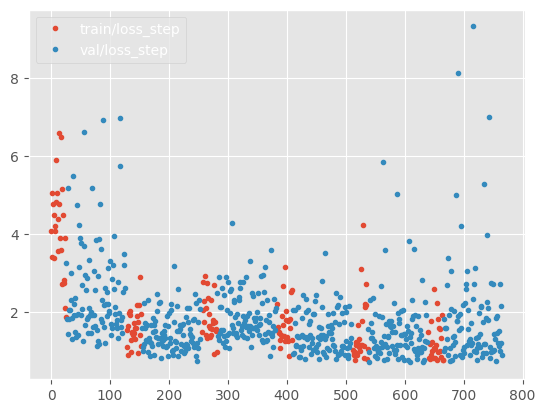

In [20]:
from src.helpers.lightning import read_metrics_csv

df_histe, df_hist = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
df_hist[["train/loss_step", "val/loss_step"]].plot(style=".")
df_hist


<Axes: xlabel='epoch'>

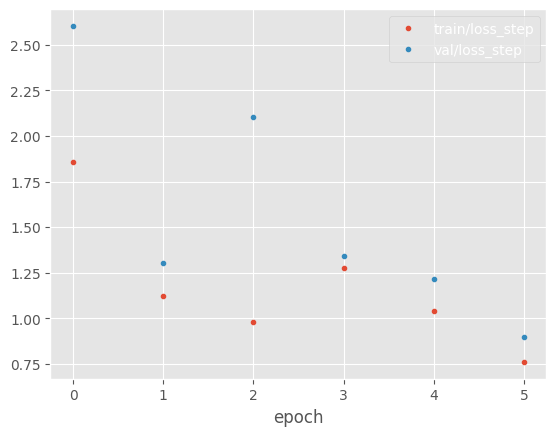

In [21]:
df_histe[["train/loss_step", "val/loss_step"]].plot(style=".")


## Generate

This acts a QC to check of the trained adapter is still coherent while giving the opposite answer


In [22]:
from src.eval.gen import gen


In [23]:

# We need to reload it from checkpoint, since lightning seems to bug it after running
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16,  # bfloat can't be pickled
    model_class=PhiForCausalLMWHS,
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


In [24]:
# Chose a row where we will see the difference
mask = (
    (ds_tokens['instructed_to_lie']==True) &
    (ds_tokens['label_true']==False)
).float()
bi = mask.argmax().item()

# TODO doesn't work if the model gets it wrong
inputs = ds_tokens.with_format("torch")[bi]
inputs['instructed_to_lie'], inputs['label_true']


(tensor(True), tensor(False))

In [25]:
with model.disable_adapter():
    gen(model, inputs, tokenizer)

gen(model, inputs, tokenizer)


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


# Test

In [26]:
from src.eval.helpers import test_intervention_quality2
from src.eval.labels import ds2label_model_obey, ds2label_model_truth

TEST_BATCH_MULT = 3


In [27]:
dm2 = DeceptionDataModule(ds_tokens2, batch_size=cfg.batch_size * TEST_BATCH_MULT)
dl_train2 = dm2.train_dataloader()
dl_train2.shuffle = False

dl_val2 = dm2.val_dataloader()
dl_test2 = dm2.test_dataloader()

dl_valtest2 = DataLoader(
    torch.utils.data.ConcatDataset([dm.datasets["val"], dm.datasets["test"]]),
    batch_size=cfg.batch_size * TEST_BATCH_MULT,
)
len(dl_valtest2.dataset)


201

In [28]:
dl_OOD = DataLoader(
    ds_tokens2, batch_size=cfg.batch_size * TEST_BATCH_MULT, drop_last=False, shuffle=False
)
len(dl_OOD.dataset)


201

In [29]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16,  # bfloat can't be pickled
    model_class=PhiForCausalLMWHS,
)
net = model_cls(model, tokenizer)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


In [30]:
from src.helpers.lightning import rename_pl_test_results

rs1 = trainer1.test(
    net,
    dataloaders=[
        dl_train2,
        dl_val2,
        dl_test2,
        dl_OOD,
    ],
    verbose=False
)
rs = rename_pl_test_results(rs1, ["train", "val", "test", "OOD"])
df_testing = pd.DataFrame(rs)
df_testing


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 3: 100%|██████████| 67/67 [01:02<00:00,  1.08it/s]


,train,val,test,OOD
loss_epoch,1.726193,1.55496,1.701327,1.67734
n,100.000000,50.00000,51.000000,201.00000


# Predict

Here we want to see if we can do a probe on the hidden states to see if it's lying...


### Collect

- see how acc each was for instructions vs truth
- see how a linear probe trained on the diff can do for truth, vs baseline

In [31]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16,  # bfloat can't be pickled
    model_class=PhiForCausalLMWHS,
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


In [32]:
from src.eval.collect import manual_collect2
from src.eval.ds import filter_ds_to_known
from src.eval.labels import LABEL_MAPPING
from src.eval.ds import qc_ds, ds2df, qc_dsdf
from src.helpers.torch_helpers import batch_to_device


In [33]:
# # for single process DEBUGING
# from src.eval.collect import generate_batches
# o = next(iter(generate_batches(dl_OOD, model)))


In [34]:
ds_out_OOD, f = manual_collect2(dl_OOD, model, dataset_name="OOD")
ds_out_valtest, f = manual_collect2(dl_valtest2, model, dataset_name="valtest")


2023-12-23 17:10:36.476 | INFO     | src.eval.collect:manual_collect2:56 - creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_OOD_52864f188c000db7
2023-12-23T17:10:36.476037+0800 INFO creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_OOD_52864f188c000db7
collecting hidden states: 100%|██████████| 67/67 [03:25<00:00,  3.06s/it]
2023-12-23 17:14:05.395 | INFO     | src.eval.collect:manual_collect2:56 - creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_valtest_6d2b18ef2a15d85b
2023-12-23T17:14:05.395943+0800 INFO creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_valtest_6d2b18ef2a15d85b
collecting hidden states: 100%|██████████| 67/67 [03:23<00:00,  3.04s/it]


### Eval

In [35]:
def analyse_intervention(ds_out, tokenizer):
    ds_known = filter_ds_to_known(ds_out, verbose=True)

    print(
        f"🥇 primary metric: predictive power (of logistic regression on top of intervened hidden states of known question)"
    )
    print(
        f"""
    The roc_auc should go up on the right given the intervented states
    """
    )
    for label_name, label_fn in LABEL_MAPPING.items():
        try:
            # fit probe
            # print('='*80)
            print(f"predicting label={label_name}")
            df_res = test_intervention_quality2(ds_known, label_fn, tokenizer)
            display(df_res)
        except Exception as e:
            raise
            print(f"Exception {e}")

    df1 = ds2df(ds_out)
    df_b = df1.rename(columns=lambda x: x.replace("_base", "")).copy()
    res_b = qc_dsdf(df_b)
    df_a = df1.rename(columns=lambda x: x.replace("_adapt", "")).copy()
    res_a = qc_dsdf(df_a)
    df_res_ab = pd.DataFrame([res_b, res_a], index=["base", "adapter"]).T
    print("🥉 secondary metric: dataset quality: performance of base model and adapter")
    display(df_res_ab)

# analyse_intervention(ds_out_OOD, tokenizer)



In [36]:
print("valtest")
analyse_intervention(ds_out_valtest, tokenizer)

print("out of sample")
analyse_intervention(ds_out_OOD, tokenizer)


valtest
select rows are 78.12% based on knowledge
🥇 primary metric: predictive power (of logistic regression on top of intervened hidden states of known question)

    The roc_auc should go up on the right given the intervented states
    
predicting label=label_model_truth


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.708333,0.65,False
predictive_diff,0.708333,0.641667,False


predicting label=label_model_obey


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.473684,0.757895,True
predictive_diff,0.473684,0.889474,True


predicting label=label_model_truth_adapt


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.850962,0.793269,False
predictive_diff,0.850962,0.884615,True


predicting label=label_model_obey_adapt


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.217172,0.333333,True
predictive_diff,0.217172,0.272727,True


predicting label=ranking_truth_telling


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.716667,0.533333,False
predictive_diff,0.716667,0.616667,False


predicting label=ranking_instruction_following


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.490385,0.802885,True
predictive_diff,0.490385,0.879808,True


🥉 secondary metric: dataset quality: performance of base model and adapter


,base,adapter
balance,0.492537,0.492537
N,201.000000,201.000000
acc,0.732673,0.534653
lie_acc,0.350000,0.570000
known_lie_acc,0.321429,0.473684
tchoice_cov,0.974656,0.988817


out of sample
select rows are 69.77% based on knowledge
🥇 primary metric: predictive power (of logistic regression on top of intervened hidden states of known question)

    The roc_auc should go up on the right given the intervented states
    
predicting label=label_model_truth


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.375,0.821429,True
predictive_diff,0.375,0.875,True


predicting label=label_model_obey


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.683036,0.950893,True
predictive_diff,0.683036,0.959821,True


predicting label=label_model_truth_adapt


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.546296,0.657407,True
predictive_diff,0.546296,0.634259,True


predicting label=label_model_obey_adapt


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.402778,0.49537,True
predictive_diff,0.402778,0.518519,True


predicting label=ranking_truth_telling


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.464286,0.482143,False
predictive_diff,0.464286,0.392857,False


predicting label=ranking_instruction_following


,roc_auc_baseline,roc_auc_interven,predictive
predictive,0.733333,0.84,True
predictive_diff,0.733333,0.888889,True


🥉 secondary metric: dataset quality: performance of base model and adapter


,base,adapter
balance,0.517413,0.517413
N,201.000000,201.000000
acc,0.670000,0.580000
lie_acc,0.306931,0.574257
known_lie_acc,0.100000,0.560000
tchoice_cov,0.797476,0.939758
